In [1]:
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio
from PIL import Image

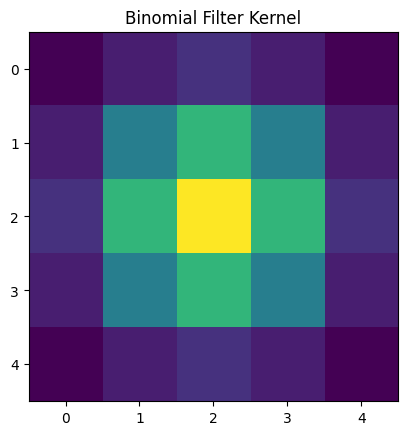

In [2]:
# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],
                             [4, 16, 24, 16, 4],
                             [6, 24, 36, 24, 6],
                             [4, 16, 24, 16, 4],
                             [1, 4, 6, 4, 1]])
plt.title('Binomial Filter Kernel')
plt.imshow(kernel)
plt.show()

In [3]:
def interpolate(image):
  """
  Interpolates an image with upsampling rate r=2.
  """
  image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
  # Upsample
  image_up[::2, ::2] = image
  # Blur (we need to scale this up since the kernel has unit area)
  # (The length and width are both doubled, so the area is quadrupled)
  #return sig.convolve2d(image_up, 4*kernel, 'same')
  return ndimage.filters.convolve(image_up,4*kernel, mode='constant')

In [4]:
def decimate(image):
  """
  Decimates an image with downsampling rate r=2.
  """
  # Blur
  #image_blur = sig.convolve2d(image, kernel, 'same')
  # print(np.shape(image), np.shape(kernel))
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
  # Downsample
  return image_blur[::2, ::2]  

In [5]:
# here is the constructions of pyramids
def pyramids(image):
  """
  Constructs Gaussian and Laplacian pyramids.
  Parameters :
  image  : the original image (i.e. base of the pyramid)
  Returns :
  G   : the Gaussian pyramid
  L   : the Laplacian pyramid
  """

  # Initialize pyramids
  G = [image, ]
  L = []

  # Build the Gaussian pyramid to maximum depth
  while image.shape[0] >= 2 and image.shape[1] >= 2:
    image = decimate(image)
    G.append(image)

  # Build the Laplacian pyramid
  for i in range(len(G) - 1):
    L.append(G[i] - interpolate(G[i + 1]))

  return G[:-1], L

  # [G, L] = pyramids(image)

In [6]:
# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
  [GA, LA] = pyramids(A)
  [GB ,LB] = pyramids(B)
  # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
  [Gmask, LMask] = pyramids(mask)
  # Form a combined pyramid LS from LA and LB using nodes of GR as weights
  # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
  # Collapse the LS pyramid to get the final blended image
  blend = []
  for i in range(len(LA)):
    # LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
    # make sure the color with in 255 (white)
    LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
    blend.append(LS)
  return blend

In [7]:
# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
  rows, cols = pyramid[0].shape
  res = np.zeros((rows, cols + cols//2), dtype= np.double)
  # start the smallest pyramid so we need to reverse the order
  revPyramid = pyramid[::-1]
  stack = revPyramid[0]
  # start with the second index
  for i in range(1, len(revPyramid)):
    stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
  return stack

In [8]:
# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask, filename):
  # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
  img1R,img1G,img1B = cv2.split(img1)
  img2R,img2G,img2B = cv2.split(img2)
  R = reconstruct(pyramidBlending(img1R, img2R, mask))
  G = reconstruct(pyramidBlending(img1G, img2G, mask))
  B = reconstruct(pyramidBlending(img1B, img2B, mask))
  output = cv2.merge((R, G, B))
  imageio.imsave(filename, output)
  return 

In [9]:
ImageA = imageio.imread('images/apple.jpg')
ImageB = imageio.imread('images/orange.jpg')
mask = cv2.imread('images/mask.jpg', 0)
mask2 = cv2.imread('images/mask2.jpeg',0)

#mask1
colorBlending(ImageA, ImageB, mask, 'result/output-apple1.png')
output1 = imageio.imread('result/output1.png')
colorBlending(ImageB, ImageA, mask, 'result/output-apple2.png')
output2 = imageio.imread('result/output2.png')

#mask2
colorBlending(ImageA, ImageB, mask2, 'result/output-apple3.png')
output3 = imageio.imread('result/output3.png')
colorBlending(ImageB, ImageA, mask2, 'result/output-apple4.png')
output4 = imageio.imread('result/output4.png')

C:\Users\User\AppData\Local\Temp\ipykernel_10688\3690464400.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageA = imageio.imread('images/apple.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\3690464400.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageB = imageio.imread('images/orange.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1036704088.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\

In [10]:
img1 = 'images/mask3.jpg'
ImageC = imageio.imread(img1)
print(ImageC.shape)
image = Image.open(img1)
image.thumbnail((512, 512))
image.save(img1)
ImageC = imageio.imread(img1)
print(ImageC.shape)


(512, 512, 3)
(512, 512, 3)


C:\Users\User\AppData\Local\Temp\ipykernel_10688\1063639539.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageC = imageio.imread(img1)
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1063639539.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageC = imageio.imread(img1)


In [11]:
print('Image A Size:',ImageA.shape)
print('Image B Size:',ImageB.shape)
print('Mask Size:',mask.shape)
print('Image Output Size:',output1.shape)

Image A Size: (512, 512, 3)
Image B Size: (512, 512, 3)
Mask Size: (512, 512)
Image Output Size: (512, 512, 3)


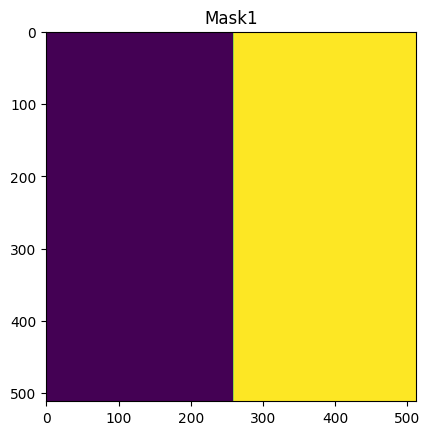

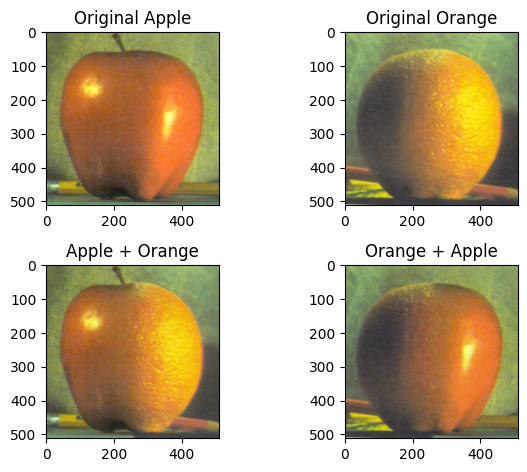

In [12]:
plt.imshow(mask)
plt.title('Mask1')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Apple')
axarr[0,1].title.set_text('Original Orange')
axarr[1,0].title.set_text('Apple + Orange')
axarr[1,1].title.set_text('Orange + Apple')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output2)
axarr[1,1].imshow(output1)
fig.tight_layout(pad=1.0)
plt.show()


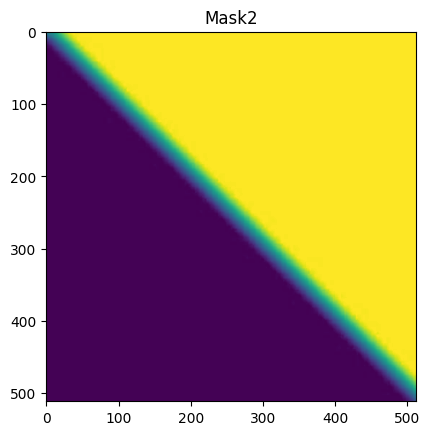

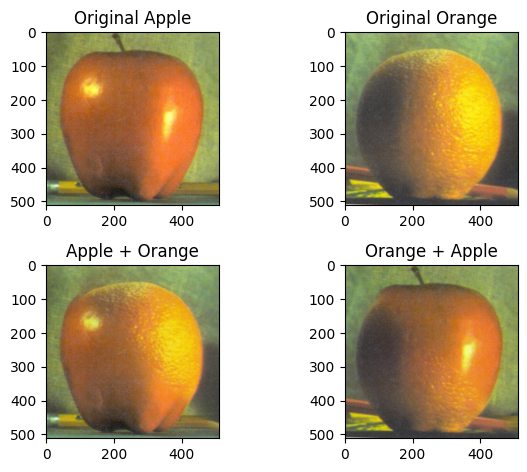

In [13]:
plt.imshow(mask2)
plt.title('Mask2')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Apple')
axarr[0,1].title.set_text('Original Orange')
axarr[1,0].title.set_text('Apple + Orange')
axarr[1,1].title.set_text('Orange + Apple')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output4)
axarr[1,1].imshow(output3)
fig.tight_layout(pad=1.0)
plt.show()

In [14]:
ImageA = imageio.imread('images/men1.jpg')
ImageB = imageio.imread('images/men2.jpg')
mask = cv2.imread('images/mask.jpg', 0)
mask2 = cv2.imread('images/mask2.jpeg',0)
mask3 = cv2.imread('images/mask3.jpg',0)

#mask1
colorBlending(ImageA, ImageB, mask, 'result/output-man1.png')
output1 = imageio.imread('result/output-man1.png')
colorBlending(ImageB, ImageA, mask, 'result/output-man2.png')
output2 = imageio.imread('result/output-man2.png')

#mask2
colorBlending(ImageA, ImageB, mask2, 'result/output-man3.png')
output3 = imageio.imread('result/output-man3.png')
colorBlending(ImageB, ImageA, mask2, 'result/output-man4.png')
output4 = imageio.imread('result/output-man4.png')

#mask3
colorBlending(ImageA, ImageB, mask3, 'result/output-man5.png')
output5 = imageio.imread('result/output-man5.png')
colorBlending(ImageB, ImageA, mask3, 'result/output-man6.png')
output6 = imageio.imread('result/output-man6.png')

C:\Users\User\AppData\Local\Temp\ipykernel_10688\2477906715.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageA = imageio.imread('images/men1.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\2477906715.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageB = imageio.imread('images/men2.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1036704088.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\Use

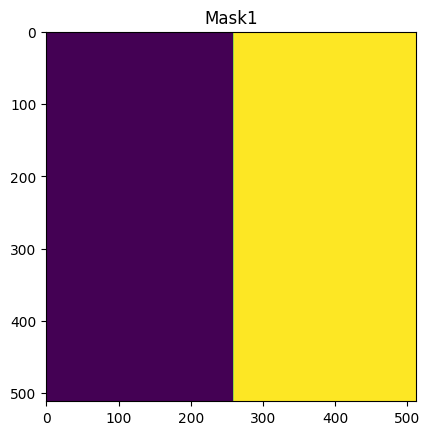

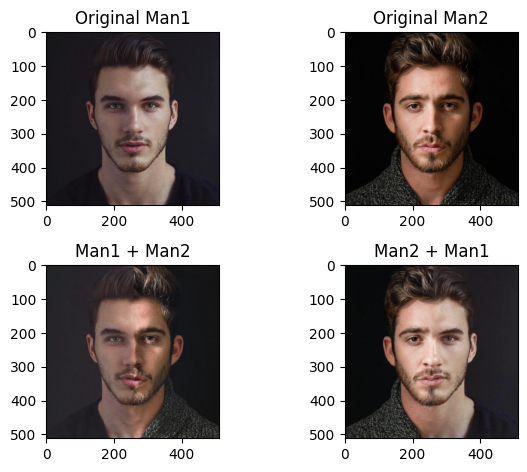

In [15]:
plt.imshow(mask)
plt.title('Mask1')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Man1')
axarr[0,1].title.set_text('Original Man2')
axarr[1,0].title.set_text('Man1 + Man2')
axarr[1,1].title.set_text('Man2 + Man1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output2)
axarr[1,1].imshow(output1)
fig.tight_layout(pad=1.0)
plt.show()

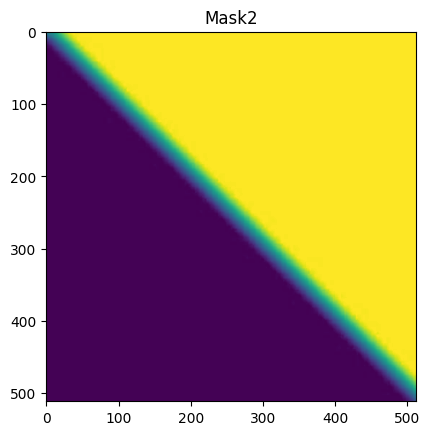

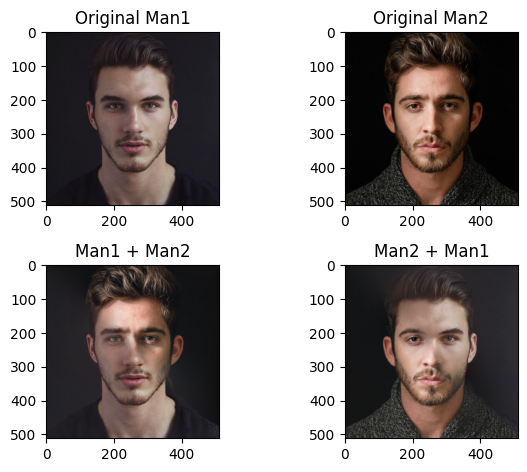

In [16]:
plt.imshow(mask2)
plt.title('Mask2')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Man1')
axarr[0,1].title.set_text('Original Man2')
axarr[1,0].title.set_text('Man1 + Man2')
axarr[1,1].title.set_text('Man2 + Man1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output4)
axarr[1,1].imshow(output3)
fig.tight_layout(pad=1.0)
plt.show()

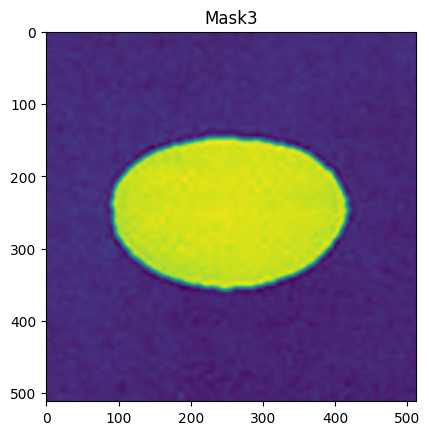

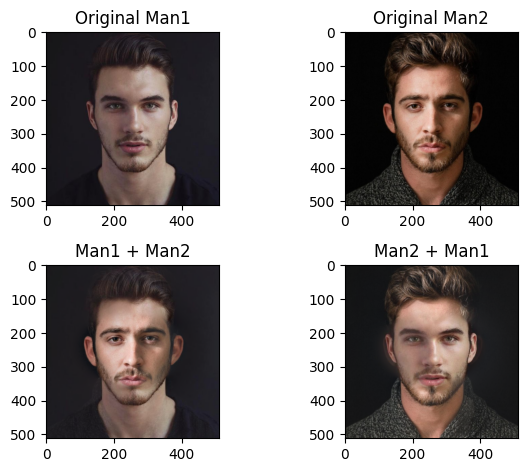

In [17]:
plt.imshow(mask3)
plt.title('Mask3')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Man1')
axarr[0,1].title.set_text('Original Man2')
axarr[1,0].title.set_text('Man1 + Man2')
axarr[1,1].title.set_text('Man2 + Man1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output6)
axarr[1,1].imshow(output5)
fig.tight_layout(pad=1.0)
plt.show()

In [18]:
ImageA = imageio.imread('images/woman5.jpg')
ImageB = imageio.imread('images/woman6.jpg')
mask = cv2.imread('images/mask.jpg', 0)
mask2 = cv2.imread('images/mask2.jpeg',0)
mask3 = cv2.imread('images/mask3.jpg', 0)

#mask1
colorBlending(ImageA, ImageB, mask, 'result/output-woman1.png')
output1 = imageio.imread('result/output-woman1.png')
colorBlending(ImageB, ImageA, mask, 'result/output-woman2.png')
output2 = imageio.imread('result/output-woman2.png')

#mask2
colorBlending(ImageA, ImageB, mask2, 'result/output-woman3.png')
output3 = imageio.imread('result/output-woman3.png')
colorBlending(ImageB, ImageA, mask2, 'result/output-woman4.png')
output4 = imageio.imread('result/output-woman4.png')

#mask3
colorBlending(ImageA, ImageB, mask3, 'result/output-woman5.png')
output5 = imageio.imread('result/output-woman5.png')
colorBlending(ImageB, ImageA, mask3, 'result/output-woman6.png')
output6 = imageio.imread('result/output-woman6.png')

C:\Users\User\AppData\Local\Temp\ipykernel_10688\4048438351.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageA = imageio.imread('images/woman5.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\4048438351.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageB = imageio.imread('images/woman6.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1036704088.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users

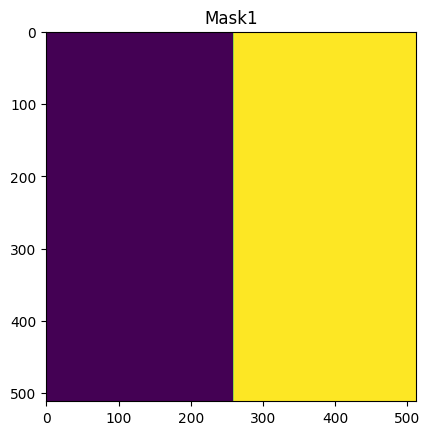

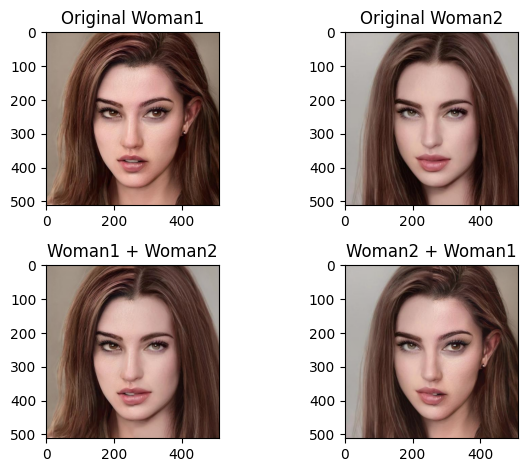

In [19]:
plt.imshow(mask)
plt.title('Mask1')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output2)
axarr[1,1].imshow(output1)
fig.tight_layout(pad=1.0)
plt.show()

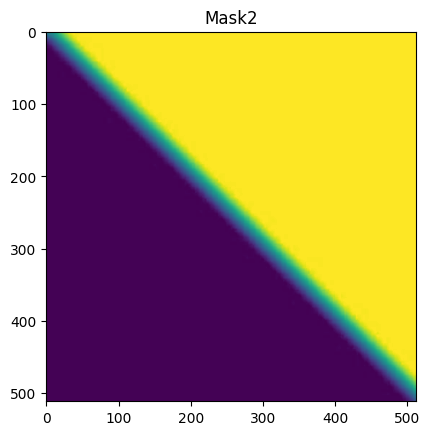

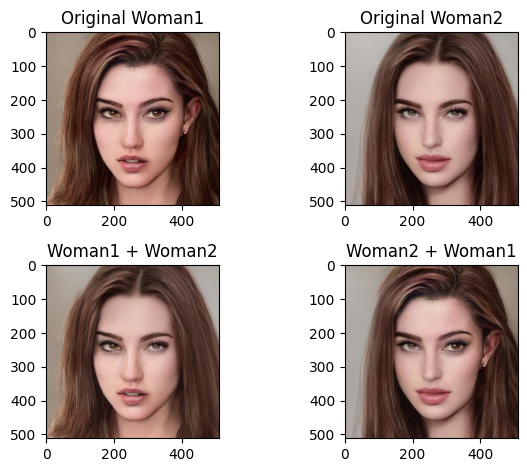

In [20]:
plt.imshow(mask2)
plt.title('Mask2')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output4)
axarr[1,1].imshow(output3)
fig.tight_layout(pad=1.0)
plt.show()

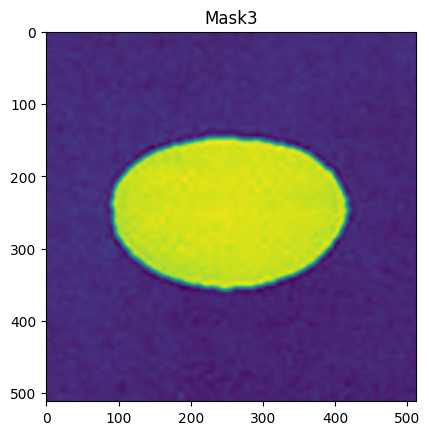

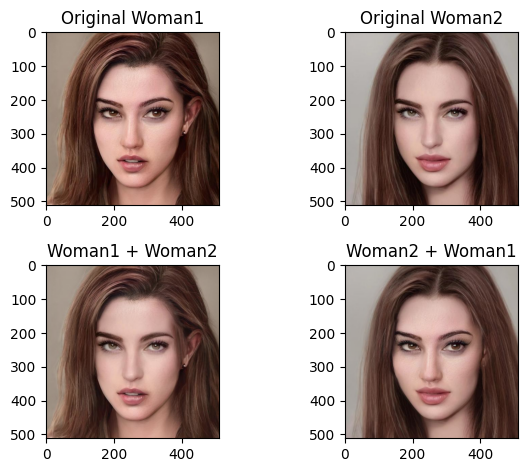

In [21]:
plt.imshow(mask3)
plt.title('Mask3')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output6)
axarr[1,1].imshow(output5)
fig.tight_layout(pad=1.0)
plt.show()

In [22]:
ImageA = imageio.imread('images/woman1.jpg')
ImageB = imageio.imread('images/woman4.jpg')
mask = cv2.imread('images/mask.jpg', 0)
mask2 = cv2.imread('images/mask2.jpeg',0)
mask3 = cv2.imread('images/mask3.jpg', 0)

#mask1
colorBlending(ImageA, ImageB, mask, 'result/output-woman7.png')
output1 = imageio.imread('result/output-woman7.png')
colorBlending(ImageB, ImageA, mask, 'result/output-woman8.png')
output2 = imageio.imread('result/output-woman8.png')

#mask2
colorBlending(ImageA, ImageB, mask2, 'result/output-woman9.png')
output3 = imageio.imread('result/output-woman9.png')
colorBlending(ImageB, ImageA, mask2, 'result/output-woman10.png')
output4 = imageio.imread('result/output-woman10.png')

#mask3
colorBlending(ImageA, ImageB, mask3, 'result/output-woman11.png')
output5 = imageio.imread('result/output-woman11.png')
colorBlending(ImageB, ImageA, mask3, 'result/output-woman12.png')
output6 = imageio.imread('result/output-woman12.png')

C:\Users\User\AppData\Local\Temp\ipykernel_10688\1716721426.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageA = imageio.imread('images/woman1.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1716721426.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ImageB = imageio.imread('images/woman4.jpg')
C:\Users\User\AppData\Local\Temp\ipykernel_10688\1036704088.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users

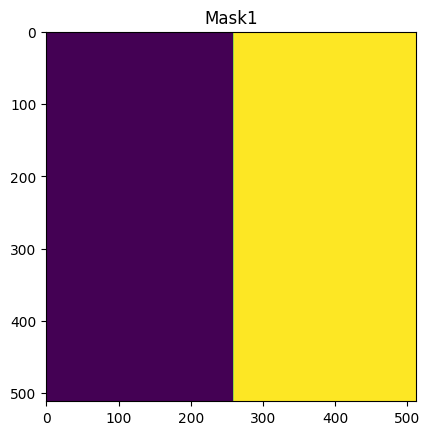

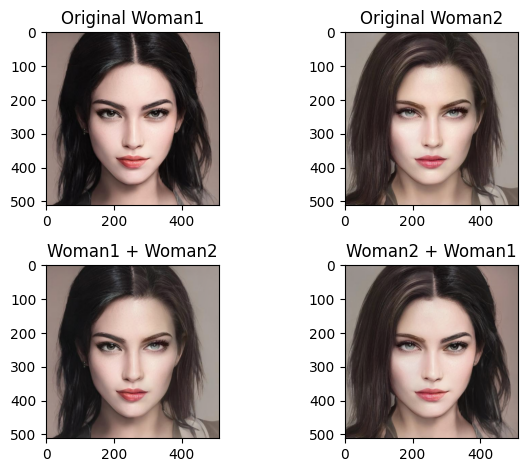

In [23]:
plt.imshow(mask)
plt.title('Mask1')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output2)
axarr[1,1].imshow(output1)
fig.tight_layout(pad=1.0)
plt.show()

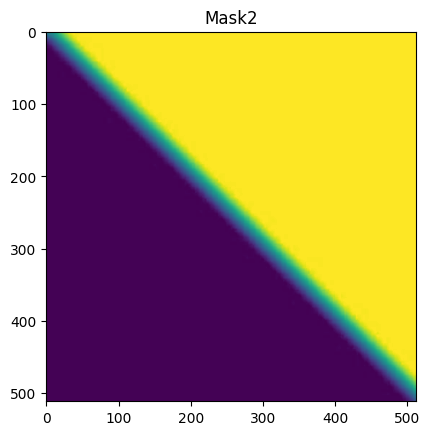

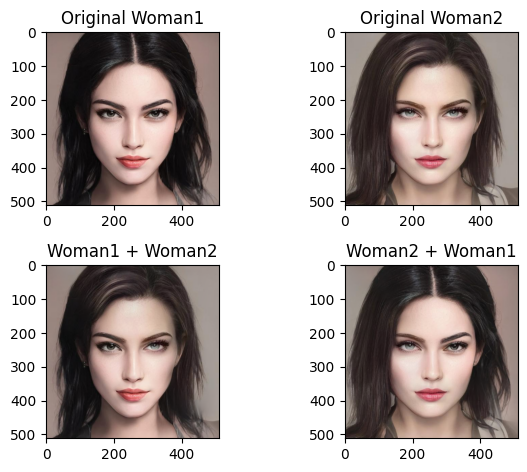

In [24]:
plt.imshow(mask2)
plt.title('Mask2')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output4)
axarr[1,1].imshow(output3)
fig.tight_layout(pad=1.0)
plt.show()

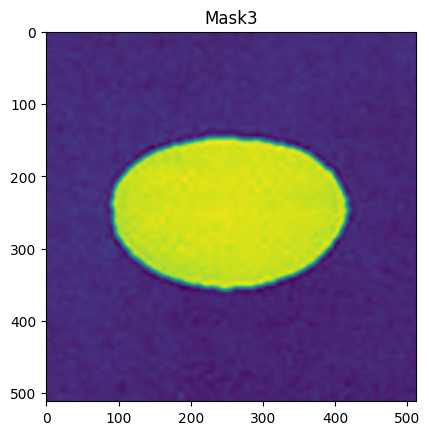

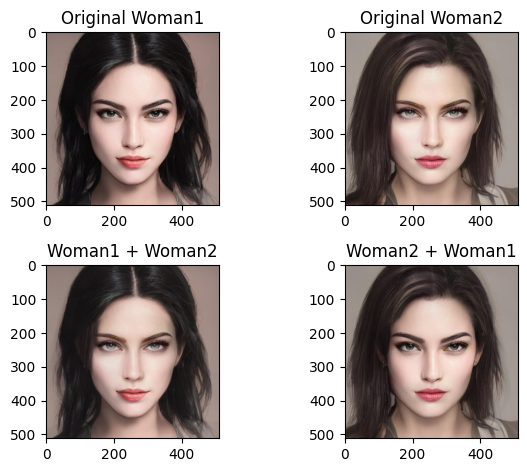

In [25]:
plt.imshow(mask3)
plt.title('Mask3')
fig, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('Original Woman1')
axarr[0,1].title.set_text('Original Woman2')
axarr[1,0].title.set_text('Woman1 + Woman2')
axarr[1,1].title.set_text('Woman2 + Woman1')
axarr[0,0].imshow(ImageA)
axarr[0,1].imshow(ImageB)
axarr[1,0].imshow(output6)
axarr[1,1].imshow(output5)
fig.tight_layout(pad=1.0)
plt.show()